In [1]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import pickle
import array_to_latex as a2l
import markdown
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import pdfkit as pdf


import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.signal import savgol_filter


In [112]:
# import sys
# !{sys.executable} -m pip install copulas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.3 MB/s eta 0:00:00


In [3]:
# import sys
# !{sys.executable} -m pip install -U tslearn

In [4]:
data = pd.read_csv(
    "./markettrends0.csv",
    dtype={
        "state": "str",
        "sa3_name16": "str",
        "sa4_name16": "str",
        "postcode": "str",
        "state": "str",
        "property_type": "str",
    },
)
ndata = data.fillna(
    {"Volume of new rental listings (1 month)": 0, "Volume of sales (1 month)": 0}
).dropna(subset=["postcode"])
ndatahouses = ndata[:][ndata.property_type == "Houses"]
ndataunits = ndata[:][ndata.property_type == "Units"]

In [5]:
UniqueNames_sa4 = ndatahouses.sa4_name16.unique()[:-1]

In [6]:
# with open('DataFrameDict_postcode.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_postcode, f)
with open('DataFrameDict_postcode.pickle', 'rb') as f:
     DataFrameDict_postcode =  pickle.load(f)    

In [7]:
aveHPI_lv3 = []
lst = ["postcode", "sa4", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2020-01" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] =np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2020-01" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa4"] = DataFrameDict_postcode[key]["sa4_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year



In [8]:
def person_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .loc[DataFrameDict_HILDAp[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1]
            .loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1].loc[
            DataFrameDict_HILDAp[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1].loc[
            DataFrameDict_HILDA[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat(postcode, lst1, lst2):
    dfHILDA1 = house_cat(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num(postcode, lst1, lst2):
    dfHILDA1 = house_num(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
lst_age = [f'hgdob{i}' for i in range(1, 21)]

def HILDAext_age(postcode):    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age].loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage




In [9]:
import re


def nan_dum(df):
    df1_ohe = df
    nan_df = df1_ohe.loc[:, df1_ohe.columns.str.endswith("_nan")]
    pattern = "^([^_]*)_"
    regex = re.compile(pattern)
    for index in df1_ohe.index:
        for col_nan in nan_df.columns:
            if df1_ohe.loc[index, col_nan] == 1:
                col_id = regex.search(col_nan).group(1)
                targets = df1_ohe.columns[df1_ohe.columns.str.startswith(col_id + "_")]
                df1_ohe.loc[index, targets] = np.nan
    df1_ohe.drop(
        df1_ohe.columns[df1_ohe.columns.str.endswith("_nan")], axis=1, inplace=True
    )
    return df1_ohe

In [10]:
varnames_catp = ["ancob", "edhigh1", "anatsi", "chkb12", "sex"]
# varnames_nump = ["wsce", "baynoa"]
varnames_nump = ["wsce"]
varnames_cath = []
#varnames_cath = ["xpgroci"]
varnames_numh = ["hsdebt"]

# UniqueNames_Hsa4 = avg_3.sa4.unique()[:-1]
# DataFrameDict_Hsa4 = {elem: pd.DataFrame for elem in UniqueNames_Hsa4}

# for key in DataFrameDict_Hsa4.keys():
#     lstpcCL= ndatahouses['postcode'].loc[ndatahouses['sa4_name16'] == key].unique()
#     lst0 = list(set(lstpcCL) - set(HILDAallpc))
#     lstpc  = list(set(lstpcCL) - set(lst0))
#     df_tmp = pd.DataFrame([])
#     for key_pc in lstpc:
#         HILDAextract_num = HILDAext_num(key_pc, varnames_numh, varnames_nump)
#         HILDAextract_cat = HILDAext_cat(key_pc, varnames_cath, varnames_catp)
#         HILDAextract_age = HILDAext_age(key_pc)
#         HILDAextract = pd.merge(HILDAextract_num, HILDAextract_cat, on="date", how="left")
#         HILDAextract = pd.merge( HILDAextract , HILDAextract_age, on="date", how="left")
#         df_tmp = pd.concat([df_tmp, HILDAextract], axis=0, ignore_index=True)
#     dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=True)})
#     list1, list2 = zip(*dfHILDA.columns)
#     dfHILDA.columns = list1
#     DataFrameDict_Hsa4[key] = dfHILDA.reset_index()    

In [11]:
with open('DataFrameDict_Hsa4.pickle', 'rb') as f:
    DataFrameDict_Hsa4 =  pickle.load(f)

In [12]:
def HILDA2PCsa4(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa4PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa4[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [13]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)

In [14]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa4.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa4 = PCA(n_components=d2)
    pca_d_sa4.fit(X_train_std)
    X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa4PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
    pcadf_sa4_date = pcadf
    return  d2, pca_d_sa4

In [15]:
def person_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1].astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat_all(lst1, lst2):
    dfHILDA1 = house_cat_all( lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num_all( lst1, lst2):
    dfHILDA1 = house_num_all(lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
lst_age = [f'hgdob{i}' for i in range(1, 21)]
def HILDAext_age_all():    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage

In [16]:
# with open('dfHILDA_cut.pickle', 'wb') as f:
#     pickle.dump(dfHILDA_cut, f)
with open('dfHILDA_cut.pickle', 'rb') as f:
      dfHILDA_cut =  pickle.load(f)    

In [17]:
with open('dfHILDA.pickle', 'rb') as f:
      dfHILDA =  pickle.load(f)    

In [18]:
threshold = 0.01
df = dfHILDA_cut.set_index("date")
df1 = df.resample("Y").mean().iloc[:, :]
vrst = pd.DataFrame([])

# need a dataframe to writedown the way to stabilize all variables
df_marks = pd.DataFrame([],
                   columns=['Variable Names', 'Approach'])


for vn in df1.columns.values[1:]:
    
    variable_tar = df1[vn]
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            new_row = {'Variable Names': vn,'Approach': suffix}
            df_marks = df_marks.append(new_row, ignore_index=True)
            newseries = pd.DataFrame(stationary_variable)
            vrst = pd.concat([vrst, newseries], axis=1)

    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                new_row = {'Variable Names': vn,'Approach': suffix}
                df_marks = df_marks.append(new_row, ignore_index=True)
                newseries = pd.DataFrame(stationary_variable)
                vrst = pd.concat([vrst, newseries], axis=1)

        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

    
    
vrdata = vrst.reset_index()
    
pca = PCA()
X_train = vrdata.loc[:, vrdata.columns != "date"]
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.9) + 1
print(d2)

pca_d_sa4 = PCA(n_components=d2)
pca_d_sa4.fit(X_train_std)
X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

PCnames = []
for i in range(1, d2 + 1, 1):
    PCnames.append(f"sa4PC{i}")
    
pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa4_date = pcadf

6


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/3248898278.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_marks = df_marks.append(new_row, ignore_index=True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/3248898278.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_marks = df_marks.append(new_row, ignore_index=True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/3248898278.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_marks = df_marks.append(new_row, ignore_index=True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/3248898278.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [19]:
marks1 = df_marks['Variable Names'].loc[df_marks['Approach'] == 'original'].values
marks2 = df_marks['Variable Names'].loc[df_marks['Approach'] == "1storderdiff"].values
marks3 = df_marks['Variable Names'].loc[df_marks['Approach'] == "2ndorderdiff"].values
def selectStationaySeries3(variable_tar, vn, marks):
    
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    marks1 =marks['Variable Names'].loc[marks['Approach'] == 'original'].values
    marks2 =marks['Variable Names'].loc[marks['Approach'] == "1storderdiff"].values
    marks3 =marks['Variable Names'].loc[marks['Approach'] == "2ndorderdiff"].values
    
    if vn in marks1:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            #print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0 and vn in marks2:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0 and vn in marks3:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                #print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     

In [20]:
def HILDA2PCsa4(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries3(df1[vn], vn, marks)], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa4PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa4[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [21]:
def HILDAvarExt(key, marks):
    df = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list( set(df_marks['Variable Names'].values) & set(df1.columns.values[1:]))
    for vn in lst:
        vrst[vn] = selectStationaySeries3(df1[vn], vn, marks)
    vrdata = vrst.reset_index().fillna(value = 0) 
    return(vrdata)


In [22]:
def PCA_val(gamma1,marks,vrdata):
    tmp = pd.DataFrame([], columns = marks['Variable Names'].values)
    for key in DataFrameDict_Hsa4.keys(): 
        df = HILDAvarExt(key,marks)
        df1= df[vrdata.columns.tolist()]
        df2 = df1.drop(df1.columns[0], axis=1)
        
        vrdata1 = vrdata.drop(vrdata.columns[0],axis=1)
        vrdata2= vrdata1.apply(lambda x: x*gamma1)
        
        df_add = df2.add(vrdata2, fill_value=0)
        tmp = pd.concat([tmp, df_add],axis = 0)
        
    pca = PCA()
    X_train = tmp
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d2 = np.argmax(cumsum >= 0.9) + 1


    pca_d_sa4 = PCA(n_components=d2)
    pca_d_sa4.fit(X_train_std)
    X_pca_d_sa4 = pca_d_sa4.transform(X_train_std)

    PCnames = []
    for i in range(1, d2 + 1, 1):
        PCnames.append(f"sa4PC{i}")
    
    pcadf = pd.DataFrame(X_pca_d_sa4, columns=PCnames)
    pcadf_sa4_date = pcadf
    return  d2, pca_d_sa4

In [24]:
x = range(0,100,1)
PCnumbers =[12,
 12,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

In [568]:
from scipy.interpolate import make_interp_spline, BSpline
# represents number of points to make between x.min and x.max
xnew =np.linspace(0, 100, 100)
spl = make_interp_spline(x, PCnumbers, k=1)  # type: BSpline
PCno_smooth = spl(xnew)

color1 = "#0085c3"
color2 = "#7ab800"
color3 = "#dc5034"

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.step(x, PCnumbers,where='post',color = color3)
ax.grid(ls=":", color="gray", alpha=0.6)

plt.xlabel(r'$\gamma$')
plt.ylabel('Number of risk factors at the SA4s level')


plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ValueError: Shapes of x (28,) and y (100,) are incompatible

In [26]:
gammaindexList = []
for i in range(12,6,-1):
   aa = min([index for index,value in enumerate(PCnumbers) if int(value)  == i])
   gammaindexList.append(aa)
gammaList = np.linspace(0, 100, 100)[gammaindexList]

In [28]:
pcadf['date'] = dfHILDA['date']  
pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
pcadf_sa4_date_new = pcadf


In [29]:
xls1 = pd.read_excel("f01hist.xls", sheet_name="Data", header=2)
xls1 = xls1.drop(xls1.index[0:8], axis=0)
xls1["Description"] = pd.to_datetime(xls1["Description"])
xls1["Description"] = xls1["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls3 = pd.read_excel("f11hist-1969-2009.xls", sheet_name="Data", header=2)
xls3 = xls3.drop(xls3.index[0:8], axis=0)
xls3["Description"] = pd.to_datetime(xls3["Description"])
xls3["Description"] = xls3["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls4 = pd.read_excel("f11hist.xls", sheet_name="Data", header=2)
xls4 = xls4.drop(xls4.index[0:8], axis=0)
xls4["Description"] = pd.to_datetime(xls4["Description"])
xls4["Description"] = xls4["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls34 = pd.concat([xls3, xls4], axis=0)
xls5 = pd.read_excel("g01hist.xls", sheet_name="Data", header=2)
xls5 = xls5.drop(xls5.index[0:8], axis=0)
xls5["Description"] = pd.to_datetime(xls5["Description"])
xls5["Description"] = xls5["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls6 = pd.read_excel("h01hist.xls", sheet_name="Data", header=2)
xls6 = xls6.drop(xls6.index[0:8], axis=0)
xls6["Description"] = pd.to_datetime(xls6["Description"])
xls6["Description"] = xls6["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls7 = pd.read_excel("h03hist.xls", sheet_name="Data", header=2)
xls7 = xls7.drop(xls7.index[0:8], axis=0)
xls7["Description"] = pd.to_datetime(xls7["Description"])
xls7["Description"] = xls7["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
# Download ASX data from Yahoo Finance

ASX200data = yf.download('^AXJO', start='1999-01-01', end='2021-06-01', interval = "1mo", progress=False)
ASX200data = ASX200data.reset_index()
ASX200data["Description"] = pd.to_datetime(ASX200data["Date"])
ASX200data["Description"] = ASX200data["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

macvar = pd.DataFrame().assign(
    Description=xls7.loc[
        ("2021-06" > xls7["Description"]) & (xls7["Description"] > "1998-12")
    ]["Description"]
)
macvar.reset_index(drop=True, inplace=True)

macvar = pd.merge(
    macvar,
    xls1[["Description", "Cash Rate Target; monthly average"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls34[["Description", "AUD/USD Exchange Rate; see notes for further detail."]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls5[["Description", "Consumer price index; All groups"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls6[["Description", "Gross domestic product (GDP); Chain volume"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Retail sales; All industries; Current price"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Private dwelling approvals"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    ASX200data[["Description", "Adj Close"]],
    on="Description",
    how="left",
)

macvar = macvar.set_axis(
    ["date", "ir", "exr", "cpi", "gdp", "rs", "pda", "asx"], axis=1, inplace=False
)


macvar["ir"] = macvar["ir"].astype(float, errors="raise")
macvar["exr"] = macvar["exr"].astype(float, errors="raise")
macvar["cpi"] = macvar["cpi"].astype(float, errors="raise")
macvar["gdp"] = macvar["gdp"].astype(float, errors="raise")
macvar["rs"] = macvar["rs"].astype(float, errors="raise")
macvar["pda"] = macvar["pda"].astype(float, errors="raise")
macvar["asx"] = macvar["asx"].astype(float, errors="raise")
macvar = macvar.interpolate()

threshold = 0.01

def selectStationaySeries(variable_tar):
        if adfuller(variable_tar.dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar
            suffix =  "original"
        elif adfuller(variable_tar.pct_change(1).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).dropna(how="all")
            suffix = "1storderdiff"
        elif adfuller(variable_tar.pct_change(3).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(3).dropna(how="all")
            suffix = "seasonaldiff"
        elif adfuller(variable_tar.pct_change(12).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(12).dropna(how="all")
            suffix = "annualdiff"     
        elif adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
            suffix = "2ndorderdiff"
        else:
            print("not found")
        return(pd.DataFrame(stationary_variable))
    
macvarst = macvar["date"] 
for vn in macvar.columns.values[1:]:
    macvarst = pd.concat([macvarst, selectStationaySeries(macvar[vn])], axis=1)

macvarsta = macvarst  
matrixmac = macvarsta.corr().round(2)
macdata = macvarsta.loc[
    ("2020-01" > macvarsta["date"]) & (macvarsta["date"] > "1999-12")
]

pca = PCA()
X_train = macdata.loc[:, macdata.columns != "date"]
poly= PolynomialFeatures(degree=2)
scaler = StandardScaler()

#X_train_poly = poly.fit_transform(X_train)
#X_train_std = scaler.fit_transform(X_train_poly)
X_train_std = scaler.fit_transform(X_train)

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

pca_d = PCA(n_components=d)
pca_d.fit(X_train_std)
X_pca_d = pca_d.transform(X_train_std)
PCnames = []
for i in range(1, d + 1, 1):
    PCnames.append(f"PC{i}")
PC_nat = pd.DataFrame(X_pca_d, columns=PCnames)

PC_nat['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2000-01")].reset_index(drop= True)["date"]
PC_nat= PC_nat.set_index("date")

6


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/3122983395.py:84: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  macvar = macvar.set_axis(
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/3122983395.py:125: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrixmac = macvarsta.corr().round(2)


In [30]:
numcols = len(X_train_std[0])
numrows = len(X_train_std)
matrixones = np.ones((numrows, numcols))
matrixdiag = np.diag(np.diag(np.ones((numcols, numcols))))

In [31]:
pca_d.transform(matrixdiag)

array([[-0.30415021, -0.04406333,  0.65239764, -0.14823615,  0.67093812,
        -0.07877896],
       [-0.61450737,  0.18722406, -0.113981  ,  0.15501654, -0.06064396,
         0.67187603],
       [-0.04087253,  0.66140468,  0.29336408,  0.03947194, -0.32647867,
        -0.4136064 ],
       [-0.19796307, -0.36187347,  0.45490099, -0.44273536, -0.63532613,
         0.09614474],
       [-0.29220424, -0.59925711, -0.14666126,  0.30274108, -0.04291215,
        -0.43075913],
       [-0.12221443,  0.06607772, -0.44896844, -0.81189832,  0.17509797,
        -0.12736877],
       [-0.62345306,  0.17641333, -0.21285224,  0.07478132, -0.05861721,
        -0.40035757]])

In [32]:
avg_1_y = aveHPIdf_lv3.groupby(["year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1_y=avg_1_y.rename(columns = {'mean':'l0'})
avg_1_y['date'] = pd.to_datetime(avg_1_y['year'].apply(str)) + pd.offsets.YearEnd()
avg_1_y = avg_1_y.set_index("date")

avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1 = avg_1.set_index("date")
avg_1=avg_1.rename(columns = {'mean':'l0'})

avg_2 = aveHPIdf_lv3.groupby(["state","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2['date'] = pd.to_datetime(avg_2['year'].apply(str)) + pd.offsets.YearEnd()
avg_2 = avg_2.set_index("date")

avg_3 = aveHPIdf_lv3.groupby(["sa4","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3=avg_3.rename(columns = {'mean':'l01'})


avg_4 = aveHPIdf_lv3.groupby(["postcode","date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_4=avg_4.rename(columns = {'mean':'l012'})


In [569]:
agg = avg_1.reset_index()
pcadf0 = PC_nat.reset_index()
pcadf = pcadf0.loc[("2020-01" > pcadf0["date"]) & (pcadf0["date"] > "2000-11")].reset_index(drop = True)

values  = agg["l0"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")].reset_index(drop=True).values
values = values.reshape((len(values), 1))

scaler1 = scaler.fit(values)
normalized  = scaler1.transform(values)
normalized_list =  [i[0] for i in normalized]
normalized_df = pd.DataFrame(normalized_list,columns = ['l0'])

pca_avg = pd.concat(
    [
        pcadf,
        normalized_df,
    ],
    axis=1,
)

df = pca_avg.iloc[:,1:]
model = VAR(df)
print(model.select_order(12).summary() )
# lag order should be one here

model_fitted = model.fit(1)
model_fitted.summary()
model_fitted_l0 =  model_fitted


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)


for col, val in zip(df.columns, out):
    print(col, ":", round(val, 2))

lag_order = model_fitted.k_ar
forecast_input = df
start_point = lag_order 

df_forecast = []
for i in range(1,df.shape[0]-lag_order+1, 1):
    forecast_input = df.values[
        -lag_order + start_point + i - 1 : start_point + i - 1,
    ]
    df_forecast.append(
        model_fitted.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )
    
values_forecast = np.array(df_forecast)
values_forecast = values_forecast.reshape((len(values_forecast), 1))
inversed = scaler1.inverse_transform(values_forecast)
inversed_list =  [i[0] for i in inversed]

lag_order_l0 = lag_order
start_point_l0 =  start_point
std_l0 = pca_avg.iloc[:,1:].std()

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -1.447      -1.339      0.2352      -1.404
1       -3.836     -2.967*     0.02158     -3.485*
2       -3.989      -2.359     0.01855      -3.331
3      -4.211*      -1.820    0.01491*      -3.245
4       -4.021     -0.8691     0.01814      -2.748
5       -3.879     0.03323     0.02112      -2.299
6       -3.962      0.7110     0.01973      -2.075
7       -3.837       1.597     0.02285      -1.642
8       -3.726       2.468     0.02627      -1.224
9       -3.745       3.210     0.02676     -0.9360
10      -3.597       4.119     0.03257     -0.4800
11      -3.526       4.951     0.03710     -0.1022
12      -3.432       5.806     0.04387      0.2996
--------------------------------------------------
PC1 : 2.02
PC2 : 2.01
PC3 : 2.22
PC4 : 2.05
PC5 : 2.07
PC6 : 2.0
l0 : 1.53


In [56]:
df = pca_avg.iloc[:,1:]
nobs = 28  # post-covid data is used as the test data set
df_train, df_test = df[0:-nobs], df[-nobs:]
# Check size

start_point = df_train.shape[0]
lag_order = model_fitted_l0.k_ar
forecast_input = df_train.values[-lag_order:]

df_forecast = []
for i in range(1, nobs + 1, 1):
    forecast_input = df.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
    df_forecast.append(
        model_fitted_l0.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )

values_forecast = np.array(df_forecast)
values_forecast = values_forecast.reshape((len(values_forecast), 1))
inversed = scaler1.inverse_transform(values_forecast)
inversed_list =  [i[0] for i in inversed]
y = inversed_list



In [570]:
date_frame = pd.DataFrame(agg["date"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2001-01")].reset_index(drop=True))
x = date_frame[-nobs:]["date"]
df_plot = pd.DataFrame({'date':x, 'l0_pred':y })
y2 = agg["l0"].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")].reset_index(drop=True)[-nobs:]
df_plot['l0'] = agg['l0'].loc[("2020-01" > agg["date"]) & (agg["date"] > "2000-11")][-nobs:].values
df_plot = df_plot.set_index('date',drop = True)

ValueError: array length 240 does not match index length 28

No handles with labels found to put in legend.


Text(0.5, 0, '')

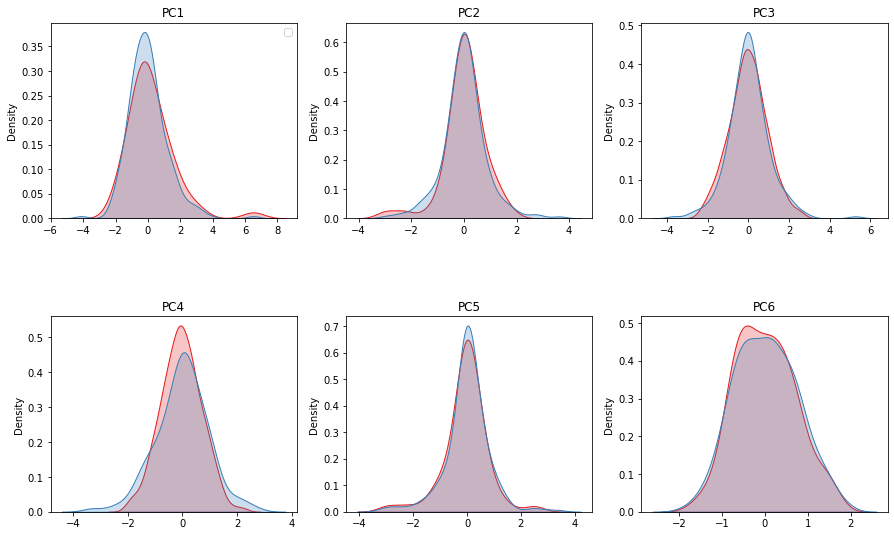

In [572]:
sim_flat_list1 = [item for sublist in DF_simResults_PC1[2:].values.tolist() for item in sublist]
sim_flat_list2 = [item for sublist in DF_simResults_PC2[2:].values.tolist() for item in sublist]
sim_flat_list3 = [item for sublist in DF_simResults_PC3[2:].values.tolist() for item in sublist]
sim_flat_list4 = [item for sublist in DF_simResults_PC4[2:].values.tolist() for item in sublist]
sim_flat_list5 = [item for sublist in DF_simResults_PC5[2:].values.tolist() for item in sublist]
sim_flat_list6 = [item for sublist in DF_simResults_PC6[2:].values.tolist() for item in sublist]
sim_flat_list_l0 = [item for sublist in DF_simResults_l0_original[2:].values.tolist() for item in sublist]

f,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharex = False, figsize = (15,9))
c1,c2,c3 = sns.color_palette('Set1',3)
plt.subplots_adjust(hspace=0.5)

sns.kdeplot(pca_avg['PC1'].sample(n=50, random_state=1),shade = True,color = c1, ax = ax1)
sns.kdeplot(pca_avg['PC1'], shade = True, color = c2,  ax = ax1)
ax1.set_title('PC1'.upper())
ax1.set_xlabel("")
ax1.legend()



sns.kdeplot(pca_avg['PC2'].sample(n=50, random_state=1),shade = True,color = c1, ax = ax2)
sns.kdeplot(pca_avg['PC2'],shade = True, color = c2, ax = ax2)
ax2.set_title('PC2'.upper())
ax2.set_xlabel("")


sns.kdeplot(sim_flat_list3, shade = True,color = c1, ax = ax3)
sns.kdeplot(pca_avg['PC3'],shade = True, color = c2, ax = ax3)
ax3.set_title('PC3'.upper())
ax3.set_xlabel("")


sns.kdeplot(sim_flat_list4, shade = True,color = c1, ax = ax4)
sns.kdeplot(pca_avg['PC4'],shade = True, color = c2, ax = ax4)
ax4.set_title('PC4'.upper())
ax4.set_xlabel("")


sns.kdeplot(pca_avg['PC5'].sample(n=50, random_state=1), shade = True,color = c1, ax = ax5)
sns.kdeplot(pca_avg['PC5'],shade = True, color = c2, ax = ax5)
ax5.set_title('PC5'.upper())
ax5.set_xlabel("")


sns.kdeplot(pca_avg['PC6'].sample(n=80, random_state=1), shade = True,color = c1, ax = ax6)
sns.kdeplot(pca_avg['PC6'],shade = True, color = c2, ax = ax6)
ax6.set_title('PC6'.upper())
ax6.set_xlabel("")



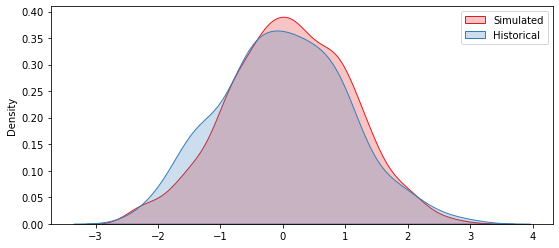

In [573]:
fig, axl0 = plt.subplots( figsize = (9,4))
sns.kdeplot(sim_flat_list_l0,shade = True,color = c1,label = 'Simulated', ax = axl0)
sns.kdeplot(pca_avg['l0'],shade = True, color = c2,label = 'Historical', ax = axl0)

axl0.set_xlabel("")
axl0.legend()


In [574]:

# fig, axl0 = plt.subplots( figsize = (9,4))
# sns.kdeplot(pca_avg['l0'].sample(n=150, random_state=1),shade = True,color = c3,label = 'Newly Simulated', ax = axl0)
# sns.kdeplot(pca_avg['l0'],shade = True, color = c2,label = 'Historical', ax = axl0)

# axl0.set_xlabel("")
# axl0.legend()


In [575]:
np.std(sim_flat_list_l0)

0.9713794741127171

In [576]:
sns.kdeplot(sim_flat_list6, shade = True,color = c1, ax = ax6)
sns.kdeplot(pca_avg['PC6'],shade = True, color = c2, ax = ax6)
ax6.set_title('PC6'.upper())


Text(0.5, 1.0, 'PC6')

In [624]:
avg_1_pred = pd.DataFrame(inversed_list, columns=["l0_forecast"])
avg_1_pred['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2000-12")].reset_index(drop= True)["date"]    
avg_1_pred  = avg_1_pred.set_index("date")


In [625]:
avg_1_pred 

,l0_forecast
date,
2000-12-31,0.006594
2001-01-31,0.006708
2001-02-28,0.014631
2001-03-31,0.013007
2001-04-30,0.013083
...,...
2019-08-31,-0.001167
2019-09-30,0.001964
2019-10-31,0.008192


In [578]:
lst_whole = list(dfHILDA.columns)
result_ancob = [i for i in lst_whole if i.startswith('ancob_')]
list_ancob0 = ['1101', '2100', '1201', '7103', '5204', '6101', '9225', '5105', '2308']
list_ancob =  ['ancob_' + sub for sub in list_ancob0]
result_edhigh = [i for i in lst_whole if i.startswith('edhigh1_')]
list_edhigh0= ['1','2','3','4','5','8','9']
list_edhigh =  ['edhigh1_' + sub for sub in list_edhigh0]
result_anatsi = [i for i in lst_whole if i.startswith('anatsi_')]
list_anatsi0= ['1','2','3','4']
list_anatsi =  ['anatsi_' + sub for sub in list_anatsi0]
result_chkb =  [i for i in lst_whole if i.startswith('chkb12_')]
list_chkb0= ['1','2','3','4']
list_chkb =  ['chkb12_' + sub for sub in list_chkb0]
list_deleted =  [i for i in lst_whole if i.startswith(('ancob_','edhigh1_','chkb12_','anatsi_'))]
list_remained = [vn for vn in lst_whole if vn not in list_deleted]
list_final = list_remained + list_ancob + list_edhigh + list_anatsi + list_chkb

In [77]:
def gamma2pre_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]

    modelsa4 = VAR(df)
    model_fitted = modelsa4.fit(lag)
    
    lag_order = model_fitted.k_ar
    forecast_input = df
    start_point = lag_order 

    df_forecast = []
    for i in range(1,df.shape[0]-lag_order+1, 1):
        forecast_input = df.values[
            -lag_order + start_point + i - 1 : start_point + i - 1,
        ]
        df_forecast.append(
            model_fitted.forecast(y=forecast_input, steps=1)[
                0,
            ][-1]
        )
    avg_3_pred_sa4 = pd.DataFrame(df_forecast, columns=["l1_forecast"])
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(avg_3_pred_sa4)

In [581]:
def gamma2rf(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(pcadf)

In [582]:
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# gamma_order = -1
# lag_list = [0,1,2,3,4,5,6,7,8]
# aic_array = np.zeros((len(gammaList), len(lag_list)))
# bic_array = np.zeros((len(gammaList), len(lag_list)))
# fpe_array = np.zeros((len(gammaList), len(lag_list)))
# hqic_array = np.zeros((len(gammaList), len(lag_list)))

# count_array = np.zeros((len(gammaList), len(lag_list)))
# for gamma1 in gammaList:
#     gamma_order = gamma_order+1
#     d3_0, pcafit_0 = PCA_val(gamma1,df_marks,vrdata)
#     for lag0 in lag_list:
#         count = 0
#         AICtotal = 0
#         BICtotal = 0 
#         FPEtotal = 0
#         HQICtotal = 0
#         #print('Initial_count: ', count)
#         for key in DataFrameDict_Hsa4.keys():    
#             try:
#                 #print(key)
#                 AICtotal = AICtotal+gamma2AIC_VAR(key, pcafit_0, d3_0, lag0)
#                 BICtotal = BICtotal+gamma2BIC_VAR(key, pcafit_0, d3_0, lag0)
#                 FPEtotal = FPEtotal+gamma2FPE_VAR(key, pcafit_0, d3_0, lag0) 
#                 HQICtotal = HQICtotal+gamma2HQIC_VAR(key, pcafit_0, d3_0, lag0)       
#                 count = count+1
#             except:
#                 #print(AICtotal)
#                 pass
#         PCnum = 12 - gamma_order    
#         print('PCnum: ', PCnum)
#         print('lag: ',lag0)
#         print('count: ',count)
            
#         avg1 = AICtotal/count 
#         avg2 = BICtotal/count
#         avg3 = FPEtotal/count
#         avg4 = HQICtotal/count
        
       

#         count_array[gamma_order][lag0] = count
#         aic_array[gamma_order][lag0] = avg1
#         bic_array[gamma_order][lag0] = avg2
#         fpe_array[gamma_order][lag0] = avg3
#         hqic_array[gamma_order][lag0] = avg4
    


In [583]:
# a2l.to_ltx(count_array)

In [584]:
# a2l.to_ltx(aic_array)

In [585]:
# a2l.to_ltx(bic_array)

In [586]:
# a2l.to_ltx(hqic_array)

In [587]:
gammaList[2]

5.050505050505051

In [588]:
import statsmodels.api as statm
from statistics import mean
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
gamma_final = gammaList[2]
d3_final, pcafit_final = PCA_val(gamma_final,df_marks,vrdata)
lag_final = 1

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in 

In [589]:
avg_3_pred_values= []
lst = ["date","sa4", "l0_fc", "l1_fc", "l01_fc"]
# Calling DataFrame constructor on list
for key in DataFrameDict_Hsa4.keys():    
    try:
        df = pd.DataFrame([], columns=lst)
        df1 = avg_1_pred.reset_index()
        df["date"] = df1["date"].loc[("2020-01" >df1["date"])& (df1["date"] > "1999-12")]
        df["sa4"] = key 
        df["l0_fc"] = df1["l0_forecast"].loc[("2020-01" >df1["date"])& (df1["date"] > "1999-12")]
        df["l1_fc"] = gamma2pre_VAR(key, pcafit_final, d3_final, lag_final)["l1_forecast"]
        df["l01_fc"]  = df["l0_fc"] + df["l1_fc"]
        avg_3_pred_values.append(df)
        
    except:
        pass

avg_3_pred = pd.concat(avg_3_pred_values)
avg_3_pred = avg_3_pred.reset_index(drop=True)
avg_3_pred['date'] = pd.to_datetime(avg_3_pred['date'],errors = 'coerce')
    

In [591]:
avg_1_pred.reset_index()

,date,l0_forecast
0,2001-01-31,0.006594
1,2001-02-28,0.006708
2,2001-03-31,0.014631
3,2001-04-30,0.013007
4,2001-05-31,0.013083
...,...,...
224,2019-09-30,-0.001167
225,2019-10-31,0.001964
226,2019-11-30,0.008192
227,2019-12-31,0.015023


In [590]:
avg_3_pred = avg_3_pred.drop(['l0_fc', 'l1_fc'], axis=1)    

In [592]:

vol_df = pd.DataFrame([], columns = list(DataFrameDict_postcode.keys()))
for key in DataFrameDict_postcode.keys():
    try:
        df = pd.DataFrame([])
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] == sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
#         month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
#         quater = [(m - 1) // 3 + 1 for m in month]
#         monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
#         quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
#         dummies = pd.concat([monthdummies, quaterdummies], axis=1)
#         df7 =  pd.concat([df6,dummies],axis =1)
        X = df6.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        
#         result = statm.OLS(y, X).fit()
        result = statm.OLS(y, X).fit()
        vol_df[key] = result.resid
        
    except:
        print(key)
        print(sa4_name)
        pass
        



4670
Wide Bay
4655
Wide Bay
4650
Wide Bay
4615
Wide Bay


NameError: name 'Rsq' is not defined

In [632]:
vol_df['date'] = PC_nat.reset_index()['date']
vol_df = vol_df.set_index('date')

from scipy.stats import kstest
df = vol_df.dropna(axis = 1, how = 'all')
Nnonnorm = 0 
pthreshold = 0.01
for postcode in df.columns:
    if kstest(df[postcode],'norm')[1]<pthreshold:
        Nnonnorm = Nnonnorm +1
    
import copulae
from copulae import EmpiricalCopula, pseudo_obs
from copulae.datasets import load_marginal_data
df  = df.loc[:, (df != 0).any(axis=0)]

df_emp = df
u = pseudo_obs(df)
emp_cop = EmpiricalCopula(u, smoothing="none")
df_vol = EmpiricalCopula.to_marginals(emp_cop.random(1000, seed=10), df)

In [597]:
def gamma2coef_VAR(key,pcafit,d3,lag):
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  
    
    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    
    
    df1 = pd.concat([pcadf,avg_1['l0']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
#     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")
    df4['l1'] = df4['l01'] - df4['l0']
    pcadf_sa4_date_new = df4.drop(['l01', 'l0'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]

    modelsa4 = VAR(df)
    model_fitted = modelsa4.fit(lag)
    coef = model_fitted.coefs[0][-1][:-1]
 
    #print("Lag Order =", lag)
    #print("AIC : ", result.aic)
    return(coef)

In [91]:
# with open('DataFrameDict_results1.pickle', 'wb') as f:
#      pickle.dump(DataFrameDict_results1, f)

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(df_new)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:31: FutureWarning: The fra

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(df_new)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:31: FutureWarning: The fra

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(df_new)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_sim = df_forecast_sim.append(df_new)
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_68988/4250440496.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

ValueError: operands could not be broadcast together with shapes (121,) (120,) 

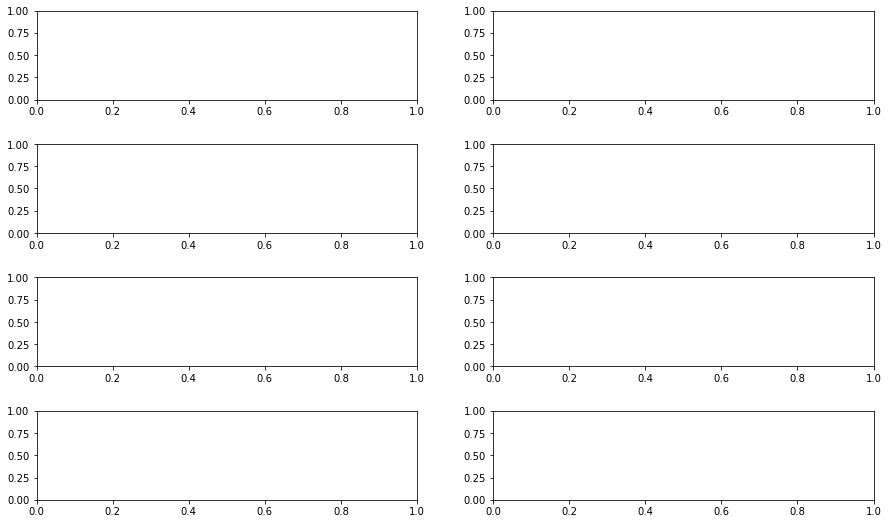

In [100]:
random.seed(111)
sim_times = 20

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 9))

plt.subplots_adjust(hspace=0.5)

color1 = '#0085c3'
color2 = '#7ab800'
color3 = '#dc5034'


mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0


DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])

for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
    for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
        forecast_input = pca_avg.values[-lag_order + start_point + i - 1 -123 : start_point + i - 1-123,1:]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)
DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)
        
    
for ax in axs.ravel():
    keypostcode = random.choice(tuple(DataFrameDict_postcode.keys()))
    keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
        (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]



    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")



    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]


    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    df_example = df
    lag_order_l1 =  lag_final
    start_point_l1 = lag_final


    model_fitted = model_fitted_l1 
    df = df_example
    lag_order = lag_order_l1
    start_point = start_point_l1 

    DF_simResults_l1 = pd.DataFrame({}, columns = ['l1'])

    for t in range(1, sim_times):
        df_forecast_sim = pd.DataFrame({},columns=df.columns)
        df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
        for i in range(1,df.iloc[-121:, ].shape[0]-lag_order+1, 1):
            forecast_input = df.values[-lag_order + start_point + i - 1 -121: start_point + i - 1-121,]
            arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
            arr_noise = np.random.normal(mu, sigma, len(df.columns))
            arr_new = np.add(arr_pred,arr_noise)
            df_new =  pd.DataFrame( arr_new ,columns=df.columns )
            df_forecast_sim = df_forecast_sim.append(df_new)
            df_forecast_sim = df_forecast_sim.reset_index(drop = True)
        DF_simResults_l1 = DF_simResults_l1.join(df_forecast_sim['l1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"] 
    DF_simResults_l1.set_index("date", inplace = True)
    DF_simResults_l1.drop(labels='l1', axis=1, inplace=True)

    DF_simResults_l1 = pd.DataFrame(scaler2.inverse_transform(DF_simResults_l1.values), index = DF_simResults_l1.index, columns =   DF_simResults_l0.columns)

    key = keypostcode
    ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
    df = DataFrameDict_postcode[key]

    z_critical = stats.norm.ppf(q = 0.95) 



    if len(df["Hedonic Home Value Index"]) > 360:
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] ==sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        result = statm.OLS(y, X).fit()

        sim_res_example = pd.DataFrame({} ) 
        for t in range(0,sim_times-1):
            predicted =  DF_simResults_l0.iloc[3:,t]+ DF_simResults_l1.iloc[2:,t]+ result.predict(X)[-120:] 
            df1 = pd.DataFrame(np.cumsum(predicted.values),columns = ['l012_sim'],index = predicted.index )
            sim_res_example = sim_res_example.join(df1['l012_sim'], how='right', rsuffix = f'_{t}') 
            sim_res_example['mean'] =  sim_res_example.quantile(0.5,axis = 1)
            sim_res_example['stdev'] = sim_res_example.std(axis=1)
            sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
            sim_res_example['Ubound'] = sim_res_example.quantile(0.95,axis = 1)
            sim_res_example['Lbound'] = sim_res_example.quantile(0.05,axis = 1)


        #         sim_res_example['Lbound'] = sim_res_example['mean'] + sim_res_example['moe']         
        #         sim_res_example['Lbound'] = sim_res_example['mean'] - sim_res_example['moe'] 

    df_final = 2**sim_res_example*100    



#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111)


    df1 =  sim_res_example.reset_index()
    x1 = df1['date'].values
    df2 = DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-12-31')&(DataFrameDict_postcode[key]['value_at_date']<'2020-01-01')]
    x2= df2['value_at_date'].values
    
    ax.plot(x1, df2['Hedonic Home Value Index'], color=color2 ,marker='.',label = 'HPI')
    ax.plot(x1,df_final['mean'] , color=color1, marker='.', label='HPI Forecasts')
    ax.plot(x1,df_final['Ubound'], color=color1,ls='--',label = 'Bounds of Confidence Interval')
    ax.plot(x1, df_final['Lbound'] , color=color1,ls='--')

    ax.grid(ls=':', color='gray', alpha=0.6)
#     ax.legend(loc='upper left', fontsize=10)
    ax.set_title(keypostcode.upper())
    ax.set_xlabel("")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(.92, 0.98))


    
                                                                                  

In [ ]:
random.seed(111)
sim_times = 100

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
fig.suptitle("HPI: True Values vs Forecasts in 8 randomly chosen suburbs", fontsize=18, y=0.95)

plt.subplots_adjust(hspace=0.5)

color1 = '#0085c3'
color2 = '#7ab800'
color3 = '#dc5034'


mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0




DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])


for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
    for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
        forecast_input = df_forecast_sim.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)

DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)

    
for ax in axs.ravel():
    keypostcode = random.choice(tuple(DataFrameDict_postcode.keys()))
    keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
        (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]



    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")



    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]


    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    df_example = df
    lag_order_l1 =  lag_final
    start_point_l1 = lag_final


    model_fitted = model_fitted_l1 
    df = df_example
    lag_order = lag_order_l1
    start_point = start_point_l1 

    DF_simResults_l1 = pd.DataFrame({}, columns = ['l1'])

    for t in range(1, sim_times):
        df_forecast_sim = pd.DataFrame({},columns=df.columns)
        df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
        for i in range(1,df.iloc[-121:, ].shape[0]-lag_order+1, 1):
            forecast_input = df_forecast_sim.values[-lag_order + start_point + i - 1 : start_point + i - 1,]
            arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
            arr_noise = np.random.normal(mu, sigma, len(df.columns))
            arr_new = np.add(arr_pred,arr_noise)
            df_new =  pd.DataFrame( arr_new ,columns=df.columns )
            df_forecast_sim = df_forecast_sim.append(df_new)
            df_forecast_sim = df_forecast_sim.reset_index(drop = True)
        DF_simResults_l1 = DF_simResults_l1.join(df_forecast_sim['l1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"] 
    DF_simResults_l1.set_index("date", inplace = True)
    DF_simResults_l1.drop(labels='l1', axis=1, inplace=True)

    DF_simResults_l1 = pd.DataFrame(scaler2.inverse_transform(DF_simResults_l1.values), index = DF_simResults_l1.index, columns =   DF_simResults_l0.columns)

    key = keypostcode
    ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
    df = DataFrameDict_postcode[key]

    z_critical = stats.norm.ppf(q = 0.95) 



    if len(df["Hedonic Home Value Index"]) > 360:
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] ==sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        result = statm.OLS(y, X).fit()

        sim_res_example = pd.DataFrame({} ) 
        for t in range(0,sim_times-1):
            predicted =  DF_simResults_l0.iloc[3:,t]+ DF_simResults_l1.iloc[2:,t]+ result.predict(X)[-120:] 
            df1 = pd.DataFrame(np.cumsum(predicted.values),columns = ['l012_sim'],index =predicted.index )
            sim_res_example = sim_res_example.join(df1['l012_sim'], how='right', rsuffix = f'_{t}') 
#             sim_res_example['mean'] =  sim_res_example.mean(axis=1)
            sim_res_example['mean'] =  sim_res_example.quantile(0.5,axis = 1)
            sim_res_example['stdev'] = sim_res_example.std(axis=1)
            sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
            sim_res_example['Ubound'] = sim_res_example.quantile(0.9,axis = 1)
            sim_res_example['Lbound'] = sim_res_example.quantile(0.1,axis = 1)


        #         sim_res_example['Lbound'] = sim_res_example['mean'] + sim_res_example['moe']         
        #         sim_res_example['Lbound'] = sim_res_example['mean'] - sim_res_example['moe'] 

    df_final = 2**sim_res_example*100    



#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111)


    df1 =  sim_res_example.reset_index()
    x1 = df1['date'].values
    df2 = DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-12-31')&(DataFrameDict_postcode[key]['value_at_date']<'2020-01-01')]
    x2= df2['value_at_date'].values

    ax.plot(x1,df_final['mean'] , color=color2, marker='.', label='HPI Forecasts')
    ax.plot(x1,df_final['Ubound'], color=color1,ls='--')
    ax.plot(x1, df_final['Lbound'] , color=color1,ls='--')
    ax.plot(x1, df2['Hedonic Home Value Index'] ,marker='.',label = 'HPI')
    ax.grid(ls=':', color='gray', alpha=0.6)
#     ax.legend(loc='upper left', fontsize=10)
    ax.set_title(keypostcode.upper())
    ax.set_xlabel("")



In [ ]:
random.seed(111)
sim_times = 100

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
fig.suptitle("HPI: True Values vs Forecasts in 8 randomly chosen suburbs", fontsize=18, y=0.95)

plt.subplots_adjust(hspace=0.5)

color1 = '#0085c3'
color2 = '#7ab800'
color3 = '#dc5034'


mu, sigma = 0, 1 
df = pca_avg.iloc[:,1:]
model_fitted = model_fitted_l0
lag_order = lag_order_l0
start_point = start_point_l0




DF_simResults_l0 = pd.DataFrame({}, columns = ['l0'])

for t in range(1, sim_times):
    df_forecast_sim = pd.DataFrame({},columns=df.columns)
    df_forecast_sim = df_forecast_sim.append(pca_avg.iloc[ -123:-121,1: ]).reset_index(drop = True)
    for i in range(1,pca_avg.iloc[ -123:,1: ].shape[0]-lag_order+1, 1):
        forecast_input = pca_avg.values[-lag_order + start_point + i - 1 -123 : start_point + i - 1-123,1:]
        arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
        arr_noise = np.random.normal(mu, sigma, len(df.columns))
        arr_new = np.add(arr_pred,arr_noise)
        df_new =  pd.DataFrame( arr_new ,columns=df.columns )
        df_forecast_sim = df_forecast_sim.append(df_new)
        df_forecast_sim = df_forecast_sim.reset_index(drop = True)
    DF_simResults_l0 = DF_simResults_l0.join(df_forecast_sim['l0'], how='right', rsuffix = f'_sim{t}')
    
DF_simResults_l0['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-10")].reset_index(drop= True)["date"] 
DF_simResults_l0.set_index("date", inplace = True)
DF_simResults_l0.drop(labels='l0', axis=1, inplace=True)
DF_simResults_l0 = pd.DataFrame(scaler1.inverse_transform(DF_simResults_l0.values), index = DF_simResults_l0.index, columns =   DF_simResults_l0.columns)
        
    
for ax in axs.ravel():
    keypostcode = random.choice(tuple(DataFrameDict_postcode.keys()))
    keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
        (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]



    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")



    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]


    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    df_example = df
    lag_order_l1 =  lag_final
    start_point_l1 = lag_final


    model_fitted = model_fitted_l1 
    df = df_example
    lag_order = lag_order_l1
    start_point = start_point_l1 

    DF_simResults_l1 = pd.DataFrame({}, columns = ['l1'])

    for t in range(1, sim_times):
        df_forecast_sim = pd.DataFrame({},columns=df.columns)
        df_forecast_sim = df_forecast_sim.append(df.iloc[-121:-119, ])
        for i in range(1,df.iloc[-121:, ].shape[0]-lag_order+1, 1):
            forecast_input = df.values[-lag_order + start_point + i - 1 -121: start_point + i - 1-121,]
            arr_pred = model_fitted.forecast(y=forecast_input, steps=1)
            arr_noise = np.random.normal(mu, sigma, len(df.columns))
            arr_new = np.add(arr_pred,arr_noise)
            df_new =  pd.DataFrame( arr_new ,columns=df.columns )
            df_forecast_sim = df_forecast_sim.append(df_new)
            df_forecast_sim = df_forecast_sim.reset_index(drop = True)
        DF_simResults_l1 = DF_simResults_l1.join(df_forecast_sim['l1'], how='right', rsuffix = f'_sim{t}')
    DF_simResults_l1['date'] = aveHPIdf_lv3.loc[("2020-01" > aveHPIdf_lv3["date"]) & (aveHPIdf_lv3["date"] > "2009-11")].reset_index(drop= True)["date"] 
    DF_simResults_l1.set_index("date", inplace = True)
    DF_simResults_l1.drop(labels='l1', axis=1, inplace=True)

    DF_simResults_l1 = pd.DataFrame(scaler2.inverse_transform(DF_simResults_l1.values), index = DF_simResults_l1.index, columns =   DF_simResults_l0.columns)

    key = keypostcode
    ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
    df = DataFrameDict_postcode[key]

    z_critical = stats.norm.ppf(q = 0.95) 



    if len(df["Hedonic Home Value Index"]) > 360:
        sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
        df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
        df_rf_nat = PC_nat
        df1 = df_rf_nat.join(df_rf_sa4)
        df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
        df3 = df2.join(avg_3.loc[avg_3['sa4'] ==sa4_name].set_index('date'))
        df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
        df4['l2'] = df4['l012'] - df4['l01']
        df5 = df4.drop(['postcode','sa4','l012', 'l01'], axis=1)    
        df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
        df6['date'] = df6['date'].astype(str)
        month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
        quater = [(m - 1) // 3 + 1 for m in month]
        monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
        quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
        dummies = pd.concat([monthdummies, quaterdummies], axis=1)
        df7 =  pd.concat([df6,dummies],axis =1)
        X = df7.iloc[:, 1:].values
        y = df5.iloc[:, -1].values
        result = statm.OLS(y, X).fit()

        sim_res_example = pd.DataFrame({} ) 
        for t in range(0,sim_times-1):
            predicted =  DF_simResults_l0.iloc[3:,t]+ DF_simResults_l1.iloc[2:,t]+ result.predict(X)[-120:] 
            DfTrue =  DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-11-30')&(DataFrameDict_postcode[key]['value_at_date']<'2019-12-31')]
            df1 = pd.DataFrame(predicted.values+np.log2(DfTrue['Hedonic Home Value Index'].values),columns = ['l012_sim'],index =predicted.index )
            sim_res_example = sim_res_example.join(df1['l012_sim'], how='right', rsuffix = f'_{t}') 
            sim_res_example['mean'] =  sim_res_example.quantile(0.5,axis = 1)
            sim_res_example['stdev'] = sim_res_example.std(axis=1)
            sim_res_example['moe'] = z_critical * (sim_res_example['stdev']/math.sqrt(sim_times))
            sim_res_example['Ubound'] = sim_res_example.quantile(0.95,axis = 1)
            sim_res_example['Lbound'] = sim_res_example.quantile(0.05,axis = 1)


        #         sim_res_example['Lbound'] = sim_res_example['mean'] + sim_res_example['moe']         
        #         sim_res_example['Lbound'] = sim_res_example['mean'] - sim_res_example['moe'] 

    df_final = 2**sim_res_example   



#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111)


    df1 =  sim_res_example.reset_index()
    x1 = df1['date'].values
    df2 = DataFrameDict_postcode[key].loc[(DataFrameDict_postcode[key]['value_at_date']>'2009-12-31')&(DataFrameDict_postcode[key]['value_at_date']<'2020-01-01')]
    x2= df2['value_at_date'].values

    ax.plot(x1,df_final['mean'] , color=color2, marker='.', label='HPI Forecasts')
    ax.plot(x1,df_final['Ubound'], color=color1,ls='--')
    ax.plot(x1, df_final['Lbound'] , color=color1,ls='--')
    ax.plot(x1, df2['Hedonic Home Value Index'] ,marker='.',label = 'HPI')
    ax.grid(ls=':', color='gray', alpha=0.6)
#     ax.legend(loc='upper left', fontsize=10)
    ax.set_title(keypostcode.upper())
    ax.set_xlabel("")




In [602]:
# important 

import copulae
from copulae import EmpiricalCopula, pseudo_obs
from copulae.datasets import load_marginal_data


In [408]:
df_vol 

,2018,2039,2037,2048,2044,2043,2010,2031,2035,2026,...,7321,0820,0810,2612,2617,2614,2607,2905,2902,2600
0,0.008925,0.022666,-0.021221,0.020455,0.026615,-0.015532,-0.019241,0.017139,0.004352,-0.003150,...,-0.019178,-0.026880,0.026880,0.025759,-0.016940,-0.015938,0.006507,0.000118,0.009211,-0.008718
1,0.002841,0.007873,-0.018081,0.008103,0.016023,-0.008251,-0.000633,-0.018061,0.003338,-0.000216,...,-0.010380,-0.002777,0.002777,-0.014109,-0.005372,-0.009883,0.008041,-0.001586,0.006168,0.016741
2,0.006319,0.018846,-0.002960,0.003868,-0.000830,-0.003178,-0.003219,-0.003212,-0.000425,0.001060,...,0.003443,0.000201,-0.000201,0.005738,0.000495,-0.006039,0.004817,0.011396,0.008033,-0.024440
3,0.002393,-0.005403,-0.006560,0.020141,-0.000513,-0.002831,-0.012631,0.002675,0.001314,-0.000812,...,-0.011386,-0.007924,0.007924,0.001337,0.000964,0.007385,-0.006169,0.004759,-0.002543,-0.005732
4,-0.000849,-0.017102,-0.013890,0.015786,0.001773,-0.001277,-0.001543,-0.008924,0.006642,0.007765,...,-0.007747,-0.014005,0.014005,0.027519,-0.012033,-0.021926,0.003772,-0.003492,-0.006453,0.012612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.007150,0.015535,-0.008896,0.014651,0.008289,-0.006231,-0.014963,-0.017255,-0.004813,0.006698,...,0.000606,-0.005605,0.005605,0.002309,-0.011848,-0.006827,0.015418,-0.001693,-0.001174,0.003815
996,0.006151,0.004638,-0.012309,0.003956,0.010056,-0.005074,-0.002778,-0.010821,0.002481,0.000586,...,-0.018838,0.002269,-0.002269,0.005163,0.002633,0.000337,-0.004829,-0.000048,-0.001013,-0.002244
997,0.004723,0.002042,0.021693,-0.007278,-0.027073,0.011393,-0.003459,0.010789,-0.010778,-0.014128,...,0.011465,0.000150,-0.000150,0.015761,-0.015004,-0.001160,0.003768,0.000486,0.000041,-0.003893
998,-0.001093,0.008113,-0.016084,0.008672,0.009832,-0.002814,0.001486,0.012622,0.005367,-0.013697,...,0.001228,-0.011133,0.011133,0.007395,-0.004984,-0.003177,0.011850,-0.006492,-0.005592,0.001000


In [410]:
from copulas.multivariate import GaussianMultivariate

In [412]:
dist_l0 = GaussianMultivariate()
dist_l0.fit(model_fitted_l0.resid)
sampled_l0 = dist_l0.sample(1000)

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


In [626]:
VAR_sa4 =  {}

for keysa4 in DataFrameDict_Hsa4.keys():
    VAR_sa4[keysa4] = {}
    key = keysa4
    d3= d3_final
    pcafit = pcafit_final
    gamma = gamma_final
    Dictdf = DataFrameDict_Hsa4[key].interpolate("bfill").interpolate("ffill").loc[:, DataFrameDict_Hsa4[key].columns != "date"]
    Xtraindata = pd.DataFrame([], columns = df_marks['Variable Names'].values)
    lst = list(set(df_marks['Variable Names'].values) & set(Dictdf.columns.values))

    for vn in lst:
        Xtraindata[vn] = Dictdf[vn]
    X_train = Xtraindata.reset_index(drop =True).fillna(value = 0)     
    scaler = StandardScaler()

    # X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train_std = scaler.fit_transform(X_train)
    X_pca_d_sa4_new = pcafit.transform(X_train_std)

    PCnames = []
    for i in range(1, d3 + 1, 1):
        PCnames.append(f"sa4PC{i}")  

    pcadf = pd.DataFrame(X_pca_d_sa4_new , columns=PCnames)
    pcadf['date'] = avg_1_y.reset_index()['date'][1:21].reset_index(drop= True)
    pcadf= pcadf.set_index("date")    

    df1 = pd.concat([pcadf,avg_1_pred['l0_forecast']], axis=1, join = "outer")
    df2 = avg_3.loc[avg_3['sa4'] == key].set_index('date')
    df3 = pd.concat([df1,df2['l01']], axis=1,join = "outer")
    #     df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
    df4 = df3.interpolate("bfill").interpolate("ffill")

    values  = (df4['l01'] - df4['l0_forecast']).values
    values = values.reshape((len(values), 1))

    scaler2 = scaler.fit(values)
    normalized  = scaler2.transform(values)
    normalized_list =  [i[0] for i in normalized]

    df4['l1'] = normalized_list


    pcadf_sa4_date_new = df4.drop(['l01', 'l0_forecast'], axis=1)
    pcadf_sa4_date_new = pcadf_sa4_date_new.reset_index() 
    df5= pcadf_sa4_date_new.loc[("2020-01" >pcadf_sa4_date_new["date"])&(pcadf_sa4_date_new["date"]> "2000-12")].reset_index(drop = True)
    df = df5.iloc[:,1:]

    modelsa4 = VAR(df)
    model_fitted_l1 = modelsa4.fit(lag_final)
    dist_l1 = GaussianMultivariate()
    dist_l1.fit(model_fitted_l1.resid)
    sampled_l1 = dist_l1.sample(200)
    
    
    VAR_sa4[keysa4]['model_fitted'] = model_fitted_l1 
    VAR_sa4[keysa4]['df'] = df
    VAR_sa4[keysa4]['sampled'] = sampled_l1
    VAR_sa4[keysa4]['scaler'] = scaler2
    


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarn

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarn

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered i

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Users/leiflyu/m

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Users/leiflyu/m

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/miniforge

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5326: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Users/leiflyu/m

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5317: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


In [265]:
from sklearn.linear_model import LinearRegression
OLS_postcode = {}
for key in DataFrameDict_postcode.keys(): 
    try:
        if sum(postcodedf["postcode"] == key) > 0:
            # ind = placepc.loc[placepc == pc].index[0]
            ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
            df = DataFrameDict_postcode[key]
            if len(df["Hedonic Home Value Index"]) > 360:
                sa4_name =  DataFrameDict_postcode[key]["sa4_name16"].unique()[0]
                df_rf_sa4 = gamma2rf(sa4_name,pcafit_final,d3_final,lag_final)
                df_rf_nat = PC_nat
                df1 = df_rf_nat.join(df_rf_sa4)
                df2 = df1.join(avg_4.loc[avg_4['postcode'] == key].set_index('date'))
                df3 = df2.join(avg_3_pred.loc[avg_3_pred['sa4'] ==sa4_name].set_index('date'))
                df4 = df3.interpolate(method='linear').interpolate(method="spline", order=1, limit_direction="both")
                df4['l2'] = df4['l012'] - df4['l01_fc']
                df5 = df4.drop(['postcode','sa4','l012', 'l01_fc'], axis=1)    
                df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
                df6['date'] = df6['date'].astype(str)
#                 df6 = df1.interpolate("bfill").interpolate("ffill").reset_index()
#                 df6['date'] = df6['date'].astype(str)
#                 month = [int(my_str.split("-")[1]) for my_str in df6["date"].values]
#                 quater = [(m - 1) // 3 + 1 for m in month]
#                 monthdummies = pd.get_dummies(month, prefix="month").iloc[:,:-1]
#                 quaterdummies = pd.get_dummies(quater, prefix="quater").iloc[:,:-1]
#                 dummies = pd.concat([monthdummies, quaterdummies], axis=1)
#                 df7 =  pd.concat([df6,dummies],axis =1)
                X = df6.iloc[:, 1:].values
                y = df5.iloc[:, -1].values
                result = statm.OLS(y, X).fit()
                model_fitted_l2 = statm.OLS(y, X).fit()
                OLS_postcode[key] = {}
                OLS_postcode[key]['model_fitted'] = model_fitted_l2
        else:
            print("area(value) %s: data incomplete" % (key))
            continue
    except:
        print(key)
        pass  


4670
4655
4650
4615


In [363]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [671]:
sim_Times = 50
    
Time = 60

Dict_arr_results ={}
for sim_time in range(0,sim_Times):
    arr_results = np.zeros(shape=(Time, len(df_vol.columns)))

    Dict_forecast_sim_sa4 =  {}
    for keysa4 in DataFrameDict_Hsa4.keys():
        df =  VAR_sa4[keysa4]['df'] 
        Dict_forecast_sim_sa4[keysa4] = np.zeros(shape=(Time+1, 11))

    
    arr_forecast_sim_l0 = np.zeros(shape=(Time+1, 7))
    arr_forecast_sim_l0[0] = pca_avg.iloc[ -1,1: ].values

    for t in range(0,Time):
    
        arr_onerow_result = np.array([])
    
        Dict_onerow_result = {}
    
        for keysa4 in DataFrameDict_Hsa4.keys():
            Dict_onerow_result[keysa4] =np.array([])
  
            forecast_input_l0 = np.zeros(shape=(1,7))
            forecast_input_l0[0] = arr_forecast_sim_l0[t] 
            arr_pred_l0 = model_fitted_l0.forecast(y=forecast_input_l0, steps=1)
    
        for keypostcode in df_vol.columns:
    
            keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
                (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]
    
            model_fitted_l1 = VAR_sa4[keysa4]['model_fitted'] 
            df =  VAR_sa4[keysa4]['df'] 
            scaler2 = VAR_sa4[keysa4]['scaler'] 

            arr_forecast_sim_l1 = Dict_forecast_sim_sa4[keysa4]

            forecast_input_l1 = np.zeros(shape=(1,11))
            forecast_input_l1[0] = arr_forecast_sim_l1[t] 
            arr_pred_l1 = model_fitted_l1.forecast(y=forecast_input_l1, steps=1)
    
            X_test = np.concatenate((arr_pred_l0[0][:-1],arr_pred_l1[0][:-1]))
        
            
        
            result0 = scaler1.inverse_transform(np.array(arr_pred_l0[0][-1]).reshape(-1, 1))+scaler2.inverse_transform(np.array(arr_pred_l0[0][-1]).reshape(-1, 1))+ OLS_postcode[keypostcode]['model_fitted'].predict(X_test)[0]
    
            some_int =  random.randint(0, 700)
            result = result0 + df_vol[keypostcode][some_int]
    
            arr_onerow_result =np.append(arr_onerow_result, result)
            Dict_onerow_result[keysa4] = np.append(Dict_onerow_result[keysa4], result)
     
    
#     df_new = pd.DataFrame(arr_onerow_result.reshape(1,-1), columns=list(DF_results))  
#     DF_results = DF_results.append(df_new)
#    DF_results = DF_results.reset_index(drop = True)
    
        arr_results[t] =  arr_onerow_result

        arr_forecast_sim_l0_onerow = np.add( sampled_l0.iloc[find_nearest(sampled_l0['l0'], mean(arr_onerow_result)- arr_pred_l0[0][-1]),].values, 
            arr_pred_l0[0])
#     df_new = pd.DataFrame(arr_forecast_sim_l0_onerow.reshape(1,-1), columns=list(df_forecast_sim_l0))
#     df_forecast_sim_l0 = df_forecast_sim_l0.append(df_new)
#     df_forecast_sim_l0 = df_forecast_sim_l0.reset_index(drop = True)
# #     df_forecast_sim_l0  = pd.concat([df_forecast_sim_l0 ,df_new])
        arr_forecast_sim_l0[t+1] =     arr_forecast_sim_l0_onerow               
    
        Dict_onerow_result_res = {k: v for k, v in Dict_onerow_result.items() if len(v) >= 1}
        for keysa4 in  Dict_onerow_result_res.keys():
            sampled_l1 = VAR_sa4[keysa4]['sampled']
            arr_onerow_result = Dict_onerow_result[keysa4]
            arr_forecast_sim_l1_onerow = np.add(sampled_l1.iloc[find_nearest(sampled_l1['l1'], mean(arr_onerow_result)- arr_pred_l1[0][-1]),].values, 
                                                arr_pred_l1[0])
            Dict_forecast_sim_sa4[keysa4][t+1] = arr_forecast_sim_l1_onerow                  
#         df_new = pd.DataFrame(arr_forecast_sim_l1_onerow.reshape(1,-1), columns=list(df_forecast_sim_l1))  
#         Dict_forecast_sim_sa4[keysa4] = Dict_forecast_sim_sa4[keysa4].append(df_new)
#         Dict_forecast_sim_sa4[keysa4] = Dict_forecast_sim_sa4[keysa4].reset_index(drop = True)
# #         Dict_forecast_sim_sa4[keysa4]  = pd.concat([Dict_forecast_sim_sa4[keysa4] ,df_new])
    Dict_arr_results[sim_time] = arr_results
                         
    
    
    
    
    
    

In [743]:
arr_60 = np.zeros(shape=(sim_Times, len(df_vol.columns)))
for sim_time in range(0,sim_Times):
    tdf= pd.DataFrame(Dict_arr_results[sim_time])
    cumsum = 2 ** tdf.cumsum()
    arr_60[sim_time] =cumsum.values[-1]
    
df_finalresults1 = pd.DataFrame(arr_60, columns = df_vol.columns) -1.2

In [744]:
ndf = pd.read_json("AUS_2021_AUST_GDA2020.json")
ndf1 = ndf["features"].apply(pd.Series)
ndf2 = ndf1["geometry"].apply(pd.Series)
ndf3 = ndf1["properties"].apply(pd.Series)

boundary = []
for index in range(0,len(ndf2['coordinates'][0])):
    tmplst = list(flatten(ndf2['coordinates'][0][index], l=depth(ndf2['coordinates'][0][index])))
    boundary = boundary+tmplst 
df_boundary = pd.DataFrame(np.reshape(boundary ,(96,2)), columns = ['longitude','latitude']) 

In [745]:
postcodecsv = pd.read_csv("au_postcodes.csv")
# References:
# https://blog.greglow.com/2019/11/05/power-bi-creating-a-topojson-file-of-australian-postcodes-for-use-with-shape-map/
# https://mapshaper.org/
# https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202016?OpenDocument

from statistics import mean, median

import pandas as pd
from scipy import stats

ndf = pd.read_json("POA_2016_AUST.json")
ndf1 = ndf["features"].apply(pd.Series)
ndf2 = ndf1["geometry"].apply(pd.Series)
ndf3 = ndf1["properties"].apply(pd.Series)
border = ndf2["coordinates"]

depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1


def flatten(d, l=1):
    for i in d:
        yield from ([i] if l == 1 else flatten(i, l - 1))


def centerlocation(index):
    tmplst = list(flatten(border[index], l=depth(border[index])))
    longi = median([i for i in tmplst if i > 0])
    lati = median([i for i in tmplst if i < 0])
    return [longi, lati]


postcodedf = []
i = 0
for i in range(len(ndf)):
    if depth(border[i]) > 0:
        tpd = {
            "postcode": [ndf3["POA_CODE16"].iloc[i]],
            "longitude": [centerlocation(i)[0]],
            "latitude": [centerlocation(i)[1]],
        }
        tpdf = pd.DataFrame(tpd)
        postcodedf.append(tpdf)
    else:
        print(i)
        continue
    i = i + 1
postcodedf = pd.concat(postcodedf, ignore_index=True)

2668
2669


In [746]:
df1 = pd.DataFrame(df_finalresults1.quantile(0.01).values, columns =['Changes' ])
df1['postcode'] = df_vol.columns

df_df1_map0 = pd.merge(postcodedf ,df1, on='postcode')
df_df1_map1 = df_df1_map0[["latitude","longitude","Changes"]]

length = len(df_df1_map1)
X = df_df1_map1[['longitude','latitude']]
y = df_df1_map1['Changes']
regressor = LinearRegression()  
regressor.fit(X, y) #training the algorithm
X_test = df_boundary[['longitude','latitude']]
y_pred = regressor.predict(X_test)
df_boundary['Changes'] = y_pred 
df_df1_map2 = pd.concat([df_df1_map1, df_boundary], ignore_index=True, sort=False)

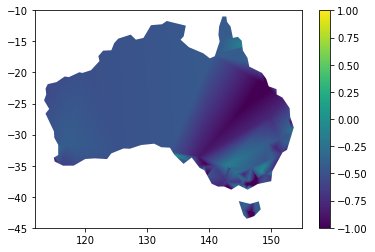

In [751]:
from scipy.interpolate import griddata
import scipy as sp
import branca
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

df1 = pd.DataFrame(df_finalresults1.quantile(0.01).values, columns =['Changes' ])
df1['postcode'] = df_vol.columns

df_df1_map0 = pd.merge(postcodedf ,df1, on='postcode')
df_df1_map1 = df_df1_map0[["latitude","longitude","Changes"]]

length = len(df_df1_map1)
X = df_df1_map1[['longitude','latitude']]
y = df_df1_map1['Changes']
regressor = LinearRegression()  
regressor.fit(X, y) #training the algorithm
X_test = df_boundary[['longitude','latitude']]
y_pred = regressor.predict(X_test)
df_boundary['Changes'] = y_pred 
df_df1_map2 = pd.concat([df_df1_map1, df_boundary], ignore_index=True, sort=False)


temp_mean = mean(df_df1_map2.Changes)
temp_std  = np.std(df_df1_map2.Changes)
debug     = False

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)

x_orig = np.asarray(df_df1_map2.longitude.tolist())
y_orig = np.asarray(df_df1_map2.latitude.tolist())
z_orig = np.asarray(df_df1_map2.Changes.tolist())

# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 2000)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 2000)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
# sigma = [5, 5]
# z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
path = Path(np.reshape(boundary ,(96,2)))
patch = PathPatch(path, facecolor ='none',edgecolor='none')

fig, ax = plt.subplots() 
ax.add_patch(patch)

# cax = ax.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)


# ax.grid(True)

# patches = []
# patches.append(patch)
# p = PatchCollection(patches, match_original = True)
# ax.add_collection(p)

im = ax.imshow(z_mesh, interpolation ='nearest', vmin = -1, vmax = 1,
               origin ='lower', extent =[112, 155, -45, -10],
               clip_path = patch, clip_on = True)
im.set_clip_path(patch)

plt.colorbar(im)
plt.show()

In [759]:
sim_Times = 50
    
Time = 60

Dict_arr_results ={}
for sim_time in range(0,sim_Times):
    arr_results = np.zeros(shape=(Time, len(df_vol.columns)))

    Dict_forecast_sim_sa4 =  {}
    for keysa4 in DataFrameDict_Hsa4.keys():
        df =  VAR_sa4[keysa4]['df'] 
        Dict_forecast_sim_sa4[keysa4] = np.zeros(shape=(Time+1, 11))

    
    arr_forecast_sim_l0 = np.zeros(shape=(Time+1, 7))
    arr_forecast_sim_l0[0] = pca_avg.iloc[ -1,1: ].values

    for t in range(0,Time):
    
        arr_onerow_result = np.array([])
    
        Dict_onerow_result = {}
    
        for keysa4 in DataFrameDict_Hsa4.keys():
            Dict_onerow_result[keysa4] =np.array([])
  
            forecast_input_l0 = np.zeros(shape=(1,7))
            forecast_input_l0[0] = arr_forecast_sim_l0[t] 
            arr_pred_l0 = model_fitted_l0.forecast(y=forecast_input_l0, steps=1)
    
        for keypostcode in df_vol.columns:
    
            keysa4 = DataFrameDict_postcode[keypostcode]["sa4_name16"].loc[
                (DataFrameDict_postcode[keypostcode]["postcode"] == keypostcode)].unique()[0]
    
            model_fitted_l1 = VAR_sa4[keysa4]['model_fitted'] 
            df =  VAR_sa4[keysa4]['df'] 
            scaler2 = VAR_sa4[keysa4]['scaler'] 

            arr_forecast_sim_l1 = Dict_forecast_sim_sa4[keysa4]

            forecast_input_l1 = np.zeros(shape=(1,11))
            forecast_input_l1[0] = arr_forecast_sim_l1[t] 
            arr_pred_l1 = model_fitted_l1.forecast(y=forecast_input_l1, steps=1)
    
            X_test = np.concatenate((arr_pred_l0[0][:-1],arr_pred_l1[0][:-1]))
        
            result0 = scaler1.inverse_transform(np.array(arr_pred_l0[0][-1]).reshape(-1, 1))+scaler2.inverse_transform(np.array(arr_pred_l0[0][-1]).reshape(-1, 1))+ OLS_postcode[keypostcode]['model_fitted'].predict(X_test)[0]
    
#            some_int =  random.randint(0, 700)
            result = result0 
    
            arr_onerow_result =np.append(arr_onerow_result, result)
            Dict_onerow_result[keysa4] = np.append(Dict_onerow_result[keysa4], result)
     
    
#     df_new = pd.DataFrame(arr_onerow_result.reshape(1,-1), columns=list(DF_results))  
#     DF_results = DF_results.append(df_new)
#    DF_results = DF_results.reset_index(drop = True)
    
        arr_results[t] =  arr_onerow_result
        
        some_int1 =  random.randint(0, 100)
        some_int2 =  random.randint(0, 100)
        
        arr_forecast_sim_l0_onerow = sampled_l0.iloc[some_int1]
#     df_new = pd.DataFrame(arr_forecast_sim_l0_onerow.reshape(1,-1), columns=list(df_forecast_sim_l0))
#     df_forecast_sim_l0 = df_forecast_sim_l0.append(df_new)
#     df_forecast_sim_l0 = df_forecast_sim_l0.reset_index(drop = True)
# #     df_forecast_sim_l0  = pd.concat([df_forecast_sim_l0 ,df_new])
        arr_forecast_sim_l0[t+1] = arr_forecast_sim_l0_onerow               
    
        Dict_onerow_result_res = {k: v for k, v in Dict_onerow_result.items() if len(v) >= 1}
        for keysa4 in  Dict_onerow_result_res.keys():
            sampled_l1 = VAR_sa4[keysa4]['sampled']
            arr_onerow_result = Dict_onerow_result[keysa4]
            arr_forecast_sim_l1_onerow =sampled_l1.iloc[some_int2]
            Dict_forecast_sim_sa4[keysa4][t+1] = arr_forecast_sim_l1_onerow                  
#         df_new = pd.DataFrame(arr_forecast_sim_l1_onerow.reshape(1,-1), columns=list(df_forecast_sim_l1))  
#         Dict_forecast_sim_sa4[keysa4] = Dict_forecast_sim_sa4[keysa4].append(df_new)
#         Dict_forecast_sim_sa4[keysa4] = Dict_forecast_sim_sa4[keysa4].reset_index(drop = True)
# #         Dict_forecast_sim_sa4[keysa4]  = pd.concat([Dict_forecast_sim_sa4[keysa4] ,df_new])
    Dict_arr_results[sim_time] = arr_results
                         
    
    

In [772]:
arr_60 = np.zeros(shape=(sim_Times, len(df_vol.columns)))
for sim_time in range(0,sim_Times):
    tdf= pd.DataFrame(Dict_arr_results[sim_time])
    cumsum = 2 ** tdf.cumsum()
    arr_60[sim_time] =cumsum.values[-1]
    
df_finalresults1 = pd.DataFrame(arr_60, columns = df_vol.columns) -1

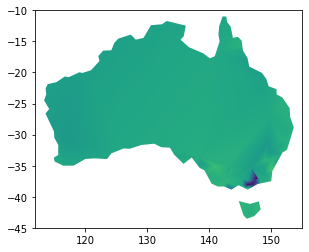

In [774]:
from scipy.interpolate import griddata
import scipy as sp
import branca
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

df1 = pd.DataFrame(df_finalresults1.quantile(0.2).values, columns =['Changes' ])
df1['postcode'] = df_vol.columns

df_df1_map0 = pd.merge(postcodedf ,df1, on='postcode')
df_df1_map1 = df_df1_map0[["latitude","longitude","Changes"]]

length = len(df_df1_map1)
X = df_df1_map1[['longitude','latitude']]
y = df_df1_map1['Changes']
regressor = LinearRegression()  
regressor.fit(X, y) #training the algorithm
X_test = df_boundary[['longitude','latitude']]
y_pred = regressor.predict(X_test)
df_boundary['Changes'] = y_pred 
df_df1_map2 = pd.concat([df_df1_map1, df_boundary], ignore_index=True, sort=False)


temp_mean = mean(df_df1_map2.Changes)
temp_std  = np.std(df_df1_map2.Changes)
debug     = False

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)

x_orig = np.asarray(df_df1_map2.longitude.tolist())
y_orig = np.asarray(df_df1_map2.latitude.tolist())
z_orig = np.asarray(df_df1_map2.Changes.tolist())

# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 2000)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 2000)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
# sigma = [5, 5]
# z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
path = Path(np.reshape(boundary ,(96,2)))
patch = PathPatch(path, facecolor ='none',edgecolor='none')

fig, ax = plt.subplots() 
ax.add_patch(patch)

# cax = ax.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)


# ax.grid(True)

# patches = []
# patches.append(patch)
# p = PatchCollection(patches, match_original = True)
# ax.add_collection(p)

im = ax.imshow(z_mesh, interpolation ='nearest', vmin = -1, vmax = 1,
               origin ='lower', extent =[112, 155, -45, -10],
               clip_path = patch, clip_on = True)
im.set_clip_path(patch)

# plt.colorbar(im)
plt.show()